# **Sensitive Text Classfication**

## **Importing Frameworks & Libraries**

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
dataset_folder="C:/Users/Subho Hazra/Desktop/Sensitive Content Analysis/text_dataset/"
sensitive='SensitiveDataset.json'
nonsensitive='NonSensitiveDataset.json'

In [7]:
vocab_size = 3000
embedding_dim = 32
max_length = 60
truncation_type='post'
padding_type='post'
oov_tok = ""
training_size = 20000

## **Pre-processing the Dataset**

In [10]:
dataList = []
sentences = []
labels = []
# Stopwords should be removed or excluded from the given text so that more 
# focus can be given to those words which define the meaning of the text.
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
    with open(dataset_folder + filename, 'r') as f:
        datastore = json.load(f)
    for item in datastore:
        sentence = item['data']
        label = item['is_sensitive']
        for word in stopwords: 
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        dataList.append([sentence, label])


loadDataset(sensitive)
loadDataset(nonsensitive)


random.shuffle(dataList)


print("Dataset Size: ", len(dataList))


for item in dataList:
    sentences.append(item[0])
    labels.append(item[1])

training_sentences = sentences[0:training_size]
validation_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
validation_labels = labels[training_size:]

print("Training Dataset Size: ", len(training_sentences))
print("Sample Training Data:", training_sentences[0])
print("Validation Dataset Size: ", len(validation_sentences))
print("Sample Validation Data:", validation_sentences[0])

Dataset Size:  31576
Training Dataset Size:  20000
Sample Training Data: Clay Halliday meets estranged brother Daniel tell father, Big Dan, dying Clay engaged Aleta Burris. Daniel surprised hear father give blessing engagement. When return ranch, obvious sparks Daniel Aleta.
Before enters father's room, Daniel flashback remembering time became estranged. His father lawman. He finds daughter, Martha, love Jivaro Burris (Aleta's brother), half-breed works Halliday ranch. Big Dan orders Jivaro off ranch. When rider attacked killed, Jivaro also attacked happened riding vicinity. Big Dan arrests Jivaro puts jail.
Big Dan leaves posse hunt rest suspected attackers despite plea Daniel to, leaving son Clay deputy guard Jivaro despite angry mob outside jail. Daniel Clay try help Jivaro escape mob enters lynched.
Daniel leaves ranch vowing never return goes Aleta's home say goodbye. Her father, Chad Burris, overhears Daniel Aleta saying not tell Big Dan's role lynching. Big Dan Clay go Burris ra

In [11]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(training_sentences)


word_index = tokenizer.word_index
print("Size of word index:", len(word_index))

with open("word_index.json", "w") as outfile:  
    json.dump(word_index, outfile)
    print("Saving the word index as JSON")


training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

# Apply the same for validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

Size of word index: 102359
Saving the word index as JSON


In [13]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

## **Model Training**

In [16]:
DESIRED_ACCURACY = 0.999
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > DESIRED_ACCURACY:
            print("Reached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, max_length))

model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 60, 32)         │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 56, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,889 (421.44 KB)

 Trainable params: 107,889 (421.44 KB)

 Non-trainable params: 0 (0.00 B)

## **Model Training**

In [17]:
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=6, 
                    validation_data=(
                        validation_padded, 
                        validation_labels), 
                    verbose=1)

Epoch 1/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.3795 - val_accuracy: 0.9779 - val_loss: 0.0769
Epoch 2/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9785 - loss: 0.0733 - val_accuracy: 0.9851 - val_loss: 0.0501
Epoch 3/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9885 - loss: 0.0408 - val_accuracy: 0.9910 - val_loss: 0.0307
Epoch 4/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9922 - loss: 0.0268 - val_accuracy: 0.9954 - val_loss: 0.0190
Epoch 5/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9946 - loss: 0.0184 - val_accuracy: 0.9965 - val_loss: 0.0113
Epoch 6/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9967 - loss: 0.0124 - val_accuracy: 0.9979 - val_loss: 0.0074


## **Plotting Accuracy and Lost Function**

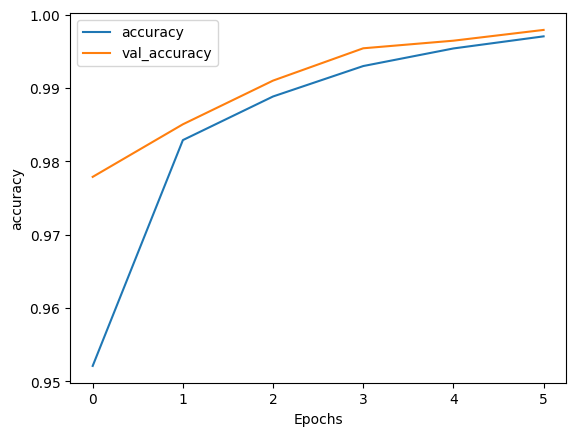

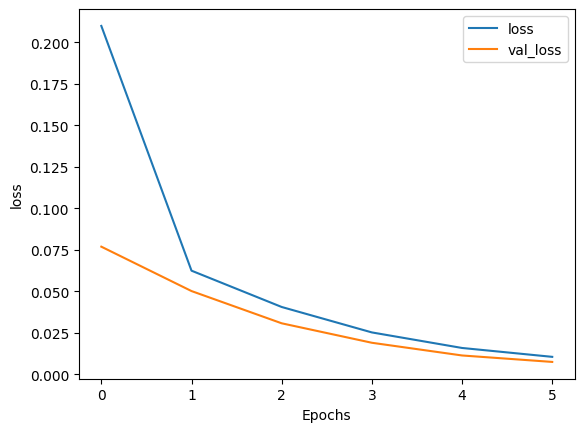

In [18]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## **Confusion Matrix**

Confusion Matrix
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy for 2894 Test Data =  99.82722874913614
Accuracy for 5788 Test Data =  99.80995162404976
Accuracy for 8682 Test Data =  99.76963833218151
Accuracy for 11576 Test Data =  99.79267449896338


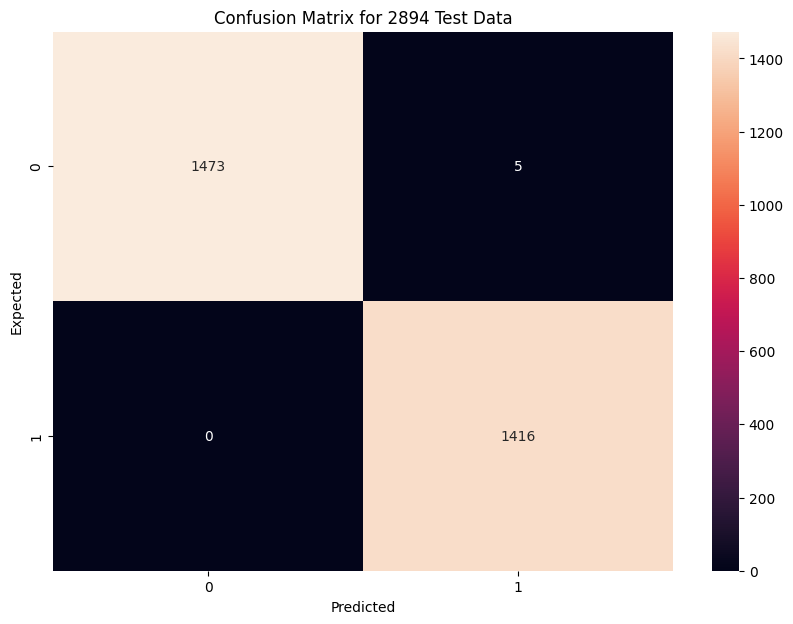

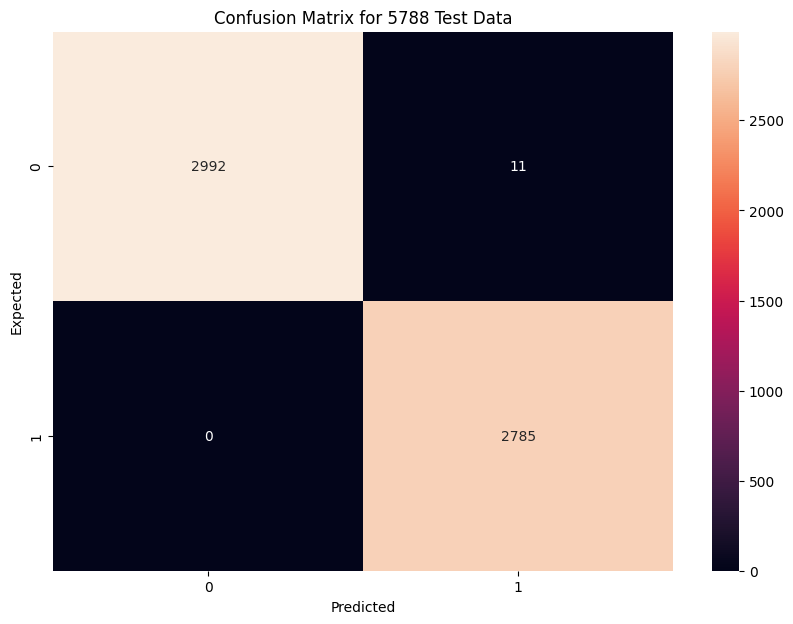

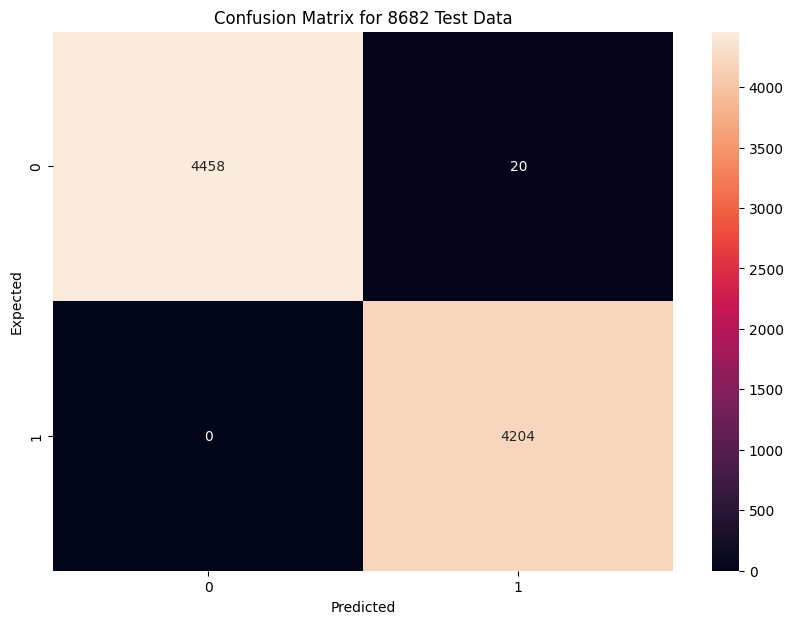

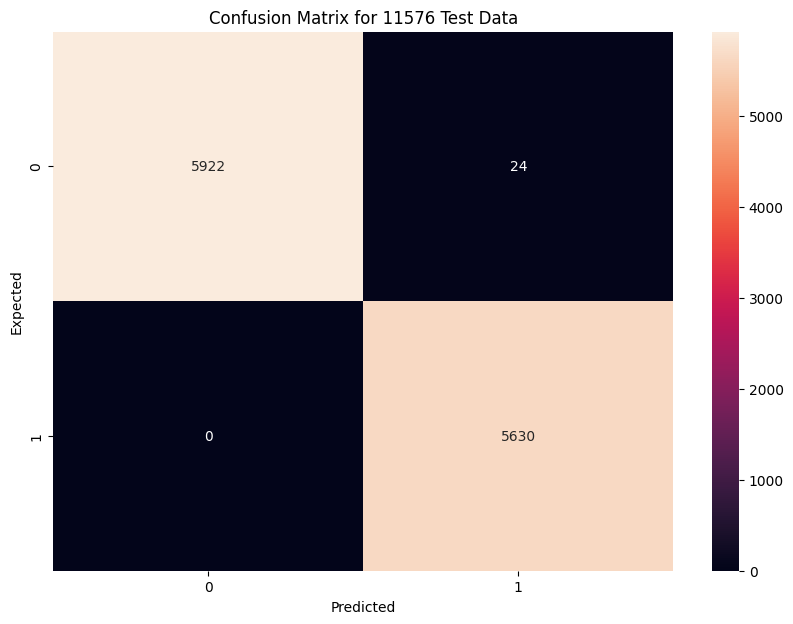

In [19]:
import seaborn
print('Confusion Matrix')
y_predicted = model.predict(validation_padded)
y_predicted_labels = y_predicted > 0.5

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
    total = i * size // 4
    cm = tf.math.confusion_matrix(labels=validation_labels[0:total],predictions=y_predicted_labels[0:total])

    cm_np = cm.numpy()
    conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
    print("Accuracy for", str(total), "Test Data = ", conf_acc)

    # Plot the confusion matrix
    plt.figure(figsize = (10,7))
    seaborn.heatmap(cm, annot=True, fmt='d')
    plt.title("Confusion Matrix for " + str(total) + " Test Data")
    plt.xlabel('Predicted')
    plt.ylabel('Expected')

## **Model Saving**

In [20]:
model.save('models/model_shweta_text.h5')
print("Saved the model successfully")

Saved the model successfully


In [21]:
model.save('models/model_subho_text.h5')
print("Saved the model successfully")

Saved the model successfully


## **Saving the file in JSON Format**

In [24]:
from tensorflow.keras.models import model_from_json

model_in_json=model.to_json()
with open('models/model_text.json','w') as json_file:
    json_file.write(model_in_json)

In [25]:
model_file=open('models/model_text.json','r')
json_model=model_file.read()
model2=model_from_json(json_model)
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 60, 32)         │        96,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 56, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,780 (842.89 KB)

 Trainable params: 107,889 (421.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 107,891 (421.45 KB)

## **Sample Example**

In [34]:
sentence = ["My credit card no is 124345346", "game of thrones season finale showing this sunday night","shweta is a Pretty Girl","subho's Phone No is : 9831581640","yes Our work is done almost babe"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
for i in range(len(predictions)):
    if predictions[i][0]>0.5:
        print("Sensitive - "+ sentence[i])
    else:
        print("Non-Sensitive - " + sentence[i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Sensitive - My credit card no is 124345346
Non-Sensitive - game of thrones season finale showing this sunday night
Sensitive - shweta is a Pretty Girl
Sensitive - subho's Phone No is : 9831581640
Sensitive - yes Our work is done almost babe
